# OxCOVID19 (https://covid19.eng.ox.ac.uk/) - Confirmed cases for United Kingdom - level 2


This notebook demonstrates how to connect to COVID19db Postgres database and how to generate country level visualisaion.

In [1]:
import psycopg2
import pandas as pd
from pandas.plotting import register_matplotlib_converters 
register_matplotlib_converters()
import matplotlib.pyplot as plt

# Connect to covid19db.org
conn = psycopg2.connect(
    host='covid19db.org',
    port=5432,
    dbname='covid19',
    user='covid19',
    password='covid19'
)

# Retrieving epidemiology data for single source

In [2]:
# Load all data for region 1
sql_command = """SELECT * FROM epidemiology WHERE source = %(source)s AND adm_area_2 <> '' ORDER by date DESC"""
df = pd.read_sql(sql_command, conn, params={'source': 'GBR_PHTW'})
df.head()

,source,date,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined,gid
0,GBR_PHTW,2020-06-08,United Kingdom,GBR,Scotland,NHS Dumfries and Galloway,None,None,261.0,None,None,None,None,None,[GBR.3.6_1]
1,GBR_PHTW,2020-06-08,United Kingdom,GBR,Scotland,NHS Greater Glasgow and Clyde,None,None,3988.0,None,None,None,None,None,"[GBR.3.9_1, GBR.3.11_1, GBR.3.16_1, GBR.3.18_1..."
2,GBR_PHTW,2020-06-08,United Kingdom,GBR,Scotland,NHS Orkney,None,None,8.0,None,None,None,None,None,[GBR.3.23_1]
3,GBR_PHTW,2020-06-08,United Kingdom,GBR,Scotland,NHS Shetland,None,None,54.0,None,None,None,None,None,[GBR.3.27_1]
4,GBR_PHTW,2020-06-08,United Kingdom,GBR,Scotland,NHS Tayside,None,None,1677.0,None,None,None,None,None,"[GBR.3.3_1, GBR.3.7_1, GBR.3.24_1]"


# Extracting only recent data - total per region

In [3]:
df_recent = df.copy()
df_recent['gid'] = [','.join(map(str, l)) for l in df['gid']]
df_recent = df_recent.sort_values('date').groupby('adm_area_2').apply(lambda x: x.max())

df_recent = df_recent.set_index('date')
df_recent['gid'] =  df_recent['gid'].str.split(',').tolist()
df_recent[["country", "adm_area_1", "confirmed", "recovered", "dead", "gid"]].head(5)

,country,adm_area_1,confirmed,recovered,dead,gid
date,,,,,,
2020-06-07,United Kingdom,Wales,1881.0,None,None,"[GBR.4.3_1, GBR.4.14_1, GBR.4.19_1]"
2020-06-07,United Kingdom,Wales,2577.0,None,None,"[GBR.4.2_1, GBR.4.4_1, GBR.4.20_1, GBR.4.13_1,..."
2020-06-08,United Kingdom,Northern Ireland,410.0,None,None,[GBR.2.1_1]
2020-06-08,United Kingdom,Northern Ireland,371.0,None,None,[GBR.2.11_1]
2020-06-08,United Kingdom,Northern Ireland,538.0,None,None,[GBR.2.2_1]


### Retrieving administrative division level 1 for single country from covid19db

In [4]:
# Get Covid19db administrative division
import geopandas as gpd
def get_administrative_division(levels_list, countrycode=None):
    sql = f"SELECT * FROM administrative_division WHERE adm_level IN {levels_list} AND countrycode='{countrycode}'"
    
    admin_data = gpd.GeoDataFrame.from_postgis(sql, conn, geom_col='geometry')
    admin_data["area"] = admin_data['geometry'].area
    return admin_data

In [5]:
admin_1_data = get_administrative_division(levels_list=(2, 3), countrycode='GBR')
admin_1_data.head()

,country,countrycode,countrycode_alpha2,adm_level,adm_area_1,adm_area_1_code,adm_area_2,adm_area_2_code,adm_area_3,adm_area_3_code,gid,latitude,longitude,properties,geometry,area
0,United Kingdom,GBR,GB,2,England,GBR.1_1,Barnsley,GBR.1.1_1,None,None,GBR.1.1_1,53.526238,-1.533560,"{'CC_2': None, 'GID_0': 'GBR', 'GID_1': 'GBR.1...","POLYGON ((-1.78997 53.47293, -1.81611 53.51611...",0.048030
1,United Kingdom,GBR,GB,3,England,GBR.1_1,Barnsley,GBR.1.1_1,Barnsley,GBR.1.1.1_1,GBR.1.1.1_1,53.526238,-1.533560,"{'CC_3': None, 'GID_0': 'GBR', 'GID_1': 'GBR.1...","POLYGON ((-1.78997 53.47293, -1.79306 53.47778...",0.047535
2,United Kingdom,GBR,GB,2,England,GBR.1_1,Bath and North East Somerset,GBR.1.2_1,None,None,GBR.1.2_1,51.355271,-2.469959,"{'CC_2': None, 'GID_0': 'GBR', 'GID_1': 'GBR.1...","POLYGON ((-2.68629 51.31516, -2.68066 51.32836...",0.045713
3,United Kingdom,GBR,GB,3,England,GBR.1_1,Bath and North East Somerset,GBR.1.2_1,Bath and North East Somerset,GBR.1.2.1_1,GBR.1.2.1_1,51.355271,-2.469959,"{'CC_3': None, 'GID_0': 'GBR', 'GID_1': 'GBR.1...","POLYGON ((-2.68629 51.31516, -2.68066 51.32836...",0.045692
4,United Kingdom,GBR,GB,2,England,GBR.1_1,Bedfordshire,GBR.1.3_1,None,None,GBR.1.3_1,52.195932,-0.489157,"{'CC_2': None, 'GID_0': 'GBR', 'GID_1': 'GBR.1...","POLYGON ((-0.58508 52.11364, -0.63161 52.14651...",0.049786


# Merge administrative division and epidemiology data

In [6]:
def get_geometry(gid_list):
    adm_regions = admin_1_data.loc[admin_1_data['gid'].isin(gid_list)]
    merged = adm_regions[['countrycode', 'geometry', 'area']].dissolve(by='countrycode')
    return merged.iloc[0]['geometry'] if merged.shape[0] > 0 else None

data_pd =df_recent.copy()
data_pd['geometry'] = data_pd['gid'].apply(lambda x: get_geometry(x))
data_pd[['longitude','latitude']] = data_pd['geometry'].apply(
    lambda x: pd.Series([x.centroid.x if x else None,x.centroid.y if x else None]))
data_pd = gpd.GeoDataFrame(data_pd, geometry='geometry')
data_pd.head()

,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined,gid,geometry,longitude,latitude
date,,,,,,,,,,,,,,,,,
2020-06-07,GBR_PHTW,United Kingdom,GBR,Wales,Abertawe Bro Morgannwg University Health Board,None,None,1881.0,None,None,None,None,None,"[GBR.4.3_1, GBR.4.14_1, GBR.4.19_1]","MULTIPOLYGON (((-4.32417 51.56625, -4.31361 51...",-3.818942,51.637355
2020-06-07,GBR_PHTW,United Kingdom,GBR,Wales,Aneurin Bevan Health Board,None,None,2577.0,None,None,None,None,None,"[GBR.4.2_1, GBR.4.4_1, GBR.4.20_1, GBR.4.13_1,...","POLYGON ((-2.79779 51.56347, -2.90306 51.53208...",-2.976271,51.715455
2020-06-08,GBR_PHTW,United Kingdom,GBR,Northern Ireland,Antrim and Newtownabbey,None,None,410.0,None,None,None,None,None,[GBR.2.1_1],"POLYGON ((-6.06583 54.62277, -6.22972 54.59166...",-6.202847,54.701138
2020-06-08,GBR_PHTW,United Kingdom,GBR,Northern Ireland,Ards and North Down,None,None,371.0,None,None,None,None,None,[GBR.2.11_1],"MULTIPOLYGON (((-5.53361 54.68319, -5.52083 54...",-5.620495,54.551201
2020-06-08,GBR_PHTW,United Kingdom,GBR,Northern Ireland,"Armagh City, Banbridge and Craigavon",None,None,538.0,None,None,None,None,None,[GBR.2.2_1],"POLYGON ((-6.36000 54.27694, -6.44500 54.26833...",-6.453196,54.370185


# TEST 1: Checking unmatched regions

### Result should be empty - if not try to correct your fetcher, probably there is a mismatch in adm_areas

In [7]:
# If this is not empty region matching has to be corrected !!!!!
unmatched_regions = data_pd[data_pd.geometry.isna()].head()
print(f"Unmatched regions: {unmatched_regions.shape[0]}")
unmatched_regions.head()

Unmatched regions: 0


,source,country,countrycode,adm_area_1,adm_area_2,adm_area_3,tested,confirmed,recovered,dead,hospitalised,hospitalised_icu,quarantined,gid,geometry,longitude,latitude
date,,,,,,,,,,,,,,,,,


In [8]:
# Remove unmatched regions
data_pd = data_pd[data_pd['geometry'].notna()].copy()

# Plotting functions

In [9]:
from termcolor import colored
import geoplot as gplt
import geoplot.crs as gcrs
import mapclassify as mc
import geoplot as gplt

def choropleth_administrative_division(data, hue, label=None, cmap='Reds', k=10, add_text=False):
    schema = mc.Quantiles(data[hue], k=k) 
    gplt.choropleth(
        data,     
        hue=hue,     
        edgecolor='white', 
        linewidth=1,
        cmap=cmap,
        scheme=schema,
        legend=True, 
        legend_kwargs={'bbox_to_anchor': (1, 0.9), 'frameon': False},
    )
    if add_text:
        label = label or hue
        for _, row in data.iterrows():
          plt.text(s=row[label], x = row['longitude'], y = row['latitude'],
                   horizontalalignment='center', 
                   fontdict = {'weight': 'bold', 'size': 10, 'family': 'serif', 'color':  'darkgray',})
        
        
def plot_time_series(data, col, check_monotonically=False):
    for key, grp in df.groupby(['adm_area_2']): 
        grp = grp[grp[col].notna()] # Drop NA
        plt.plot(grp.date, grp[col], '-o', linewidth=4.0, label=key)
        if not grp[col].is_monotonic_decreasing and check_monotonically:
            print(colored(f'Series in not monotonic increasing: {key}', 'red'))
            print(grp[['date', col]])

    plt.legend(loc='center left', bbox_to_anchor=(1.2, 0.5)) 
    plt.grid()
    plt.title(f'{col} cases per adm_area_2');
    plt.show()

# Plot epidemiology total confirmed

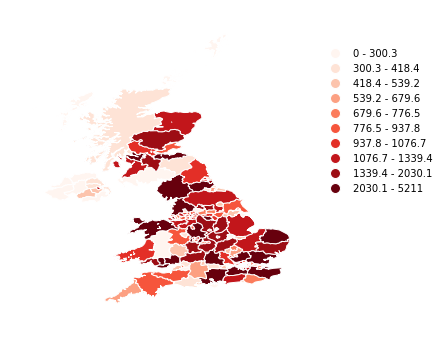

In [10]:
data_pd['confirmed'].fillna(0, inplace = True)
choropleth_administrative_division(data_pd, 'confirmed', add_text=False)

# Confirmed cases

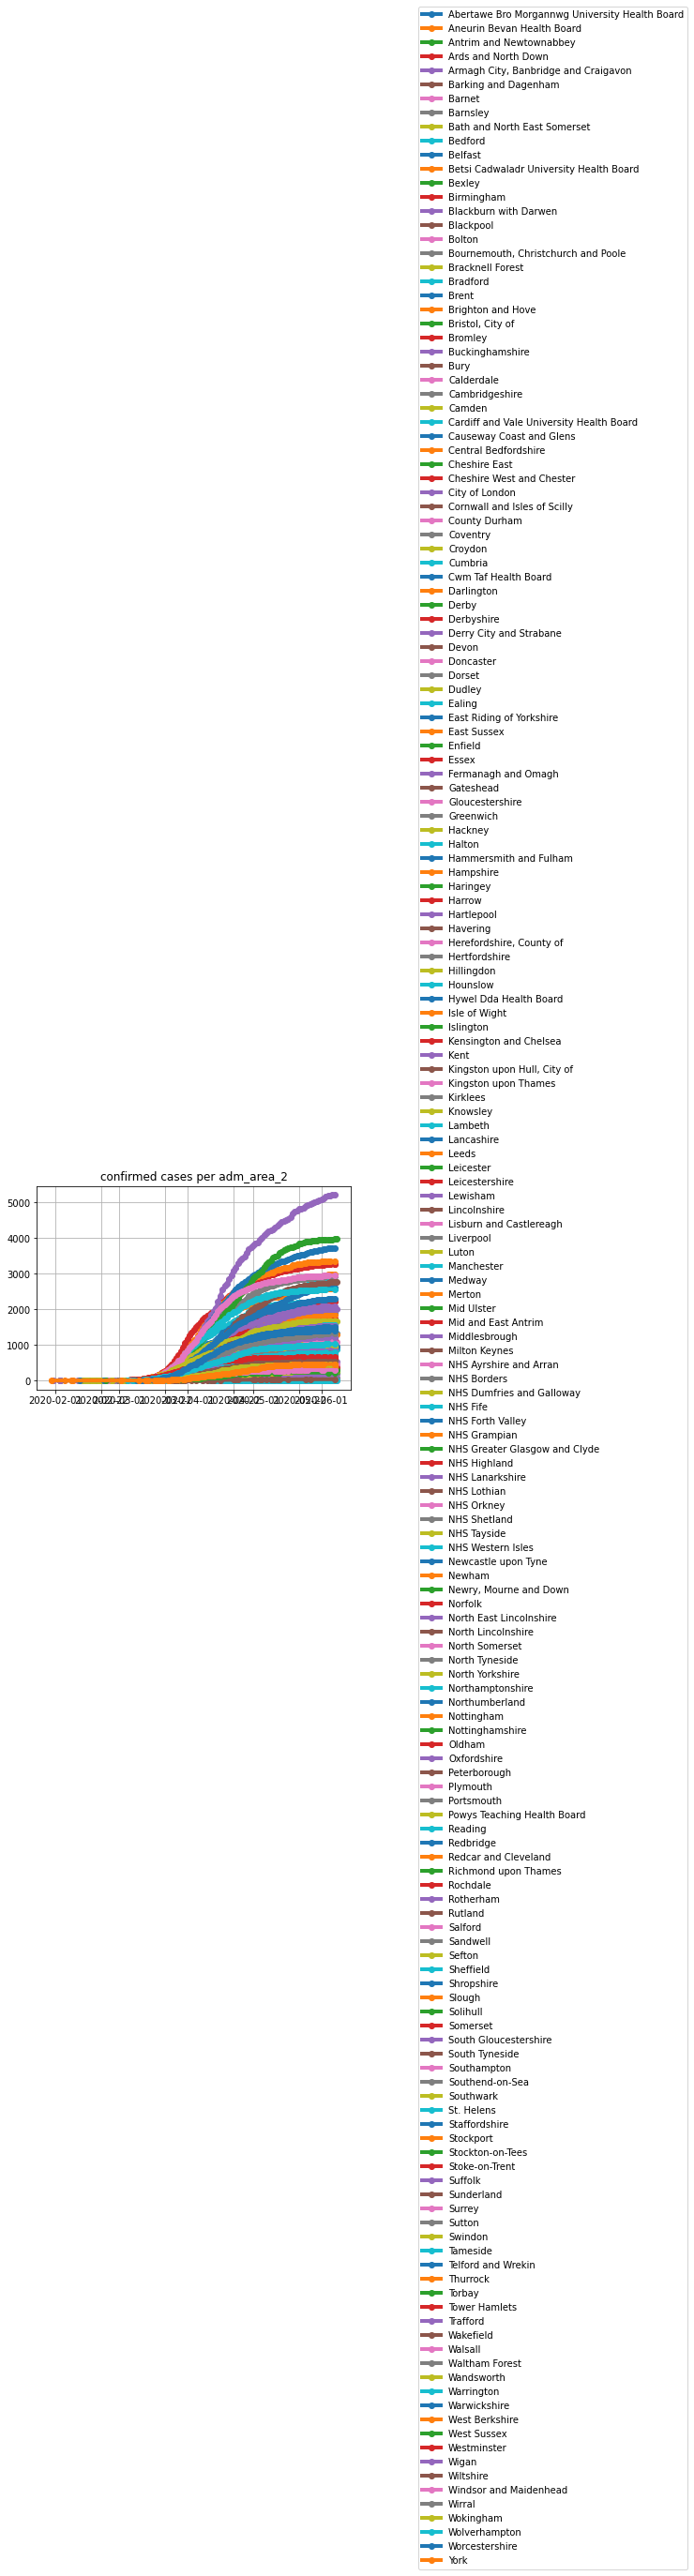

In [11]:
plot_time_series(df, 'confirmed')